# Libraries 📚

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay,
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Our dataset 🧐

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


## EDA 🔎

In [6]:
# missing values
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [7]:
# Duplicates
dup = data.duplicated().sum() / len(data) * 100
print(f"Percentage of duplicated rows is {dup.round(2)}%")

Percentage of duplicated rows is 94.44%


### Distribution

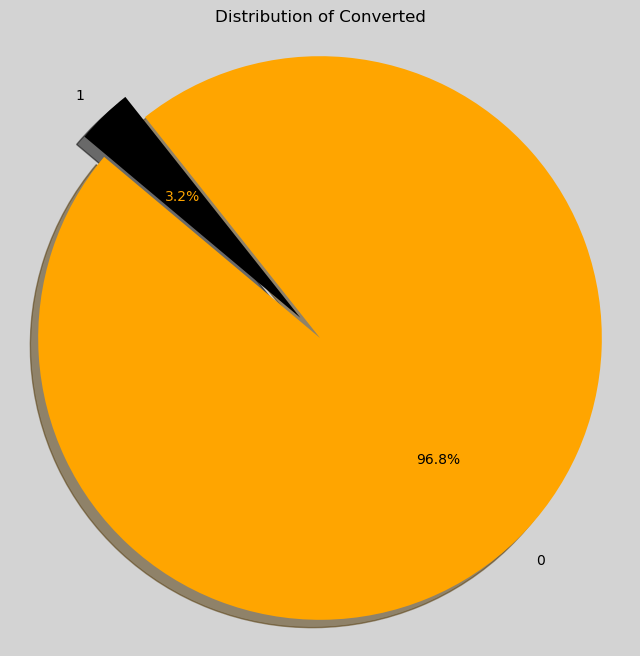

In [8]:
# target distribution
converted_counts = data['converted'].value_counts()

plt.figure(figsize=(8, 8), facecolor = "lightgrey")
patches, texts, autotexts  = plt.pie(converted_counts, labels=converted_counts.index, autopct='%1.1f%%', startangle=140, colors = ["orange", "black"], explode=(0.1, 0), shadow=True)
autotexts[1].set_color('orange')
plt.title('Distribution of Converted')
plt.axis('equal')
plt.show()

- Target disribution is unbalanced
- No missing values
- 284580 rows, 3 categorical features, 2 numerical features
- 94.44% of rows are duplicated

C:\Users\Malika\AppData\Local\Temp\ipykernel_15204\68266449.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(data=data, x='country', order=data['country'].value_counts().index, palette='inferno')


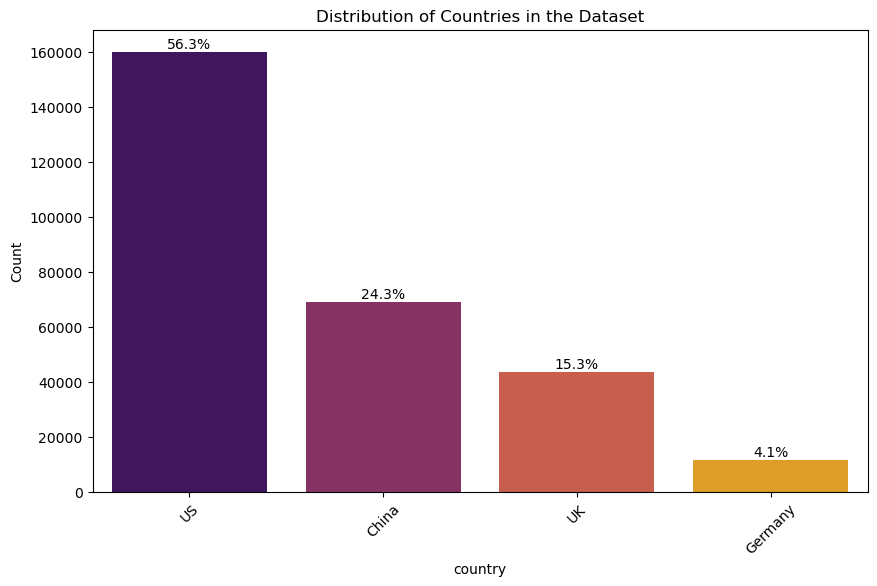

In [9]:
# Categorical features distibution
# Country

plt.figure(figsize=(10, 6))
 
count_plot = sns.countplot(data=data, x='country', order=data['country'].value_counts().index, palette='inferno')

total_counts = len(data)

for p in count_plot.patches:
    height = p.get_height() 
    percentage = (height / total_counts) * 100  
    count_plot.annotate(f'{percentage:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom') 

plt.xticks(rotation=45)
plt.title('Distribution of Countries in the Dataset')
plt.ylabel('Count')
plt.show()

C:\Users\Malika\AppData\Local\Temp\ipykernel_15204\3684879017.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count_plot = sns.countplot(data=data, x='source', order=data['source'].value_counts().index, palette='inferno')


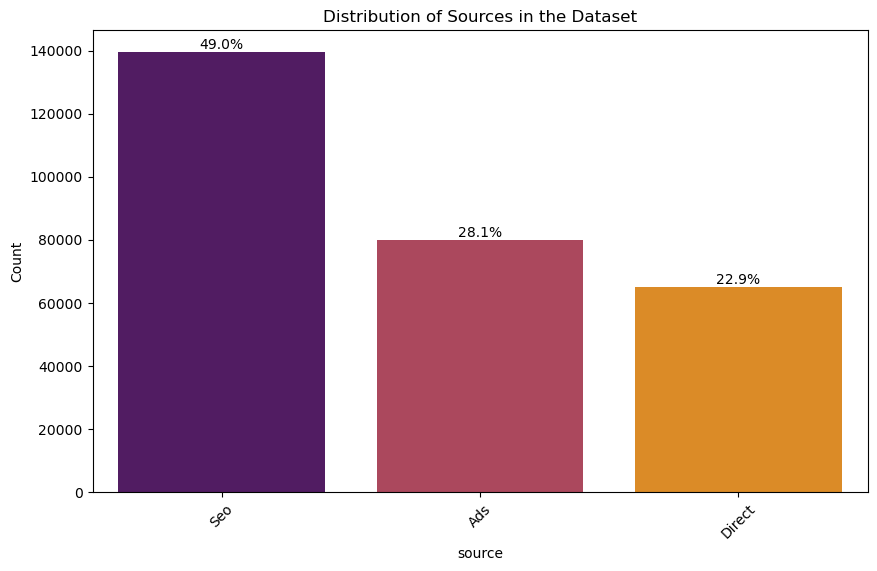

In [10]:
# Sources 

plt.figure(figsize=(10, 6))
count_plot = sns.countplot(data=data, x='source', order=data['source'].value_counts().index, palette='inferno')

total_counts = len(data)

for p in count_plot.patches:
    height = p.get_height() 
    percentage = (height / total_counts) * 100  
    count_plot.annotate(f'{percentage:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom') 

plt.xticks(rotation=45)
plt.title('Distribution of Sources in the Dataset')
plt.ylabel('Count')
plt.show()


Outliers

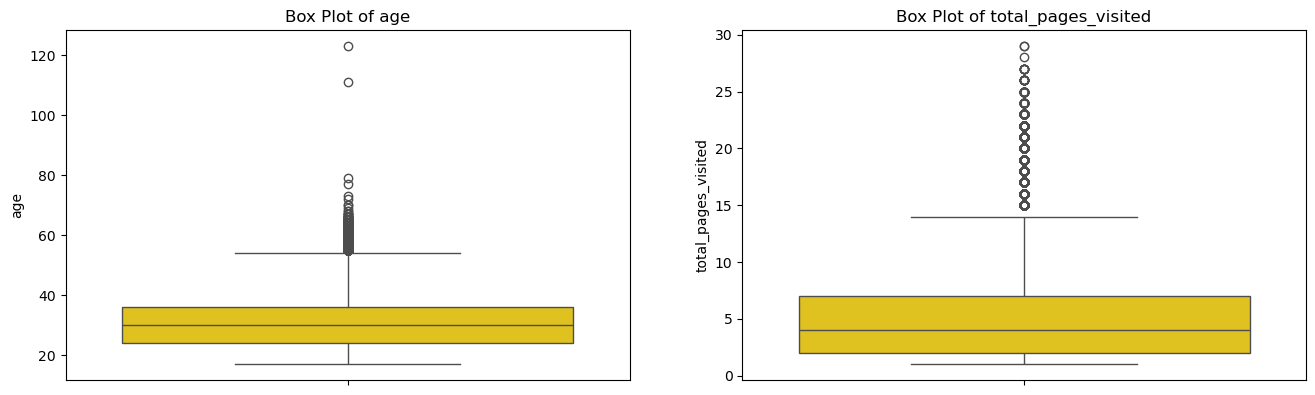

In [11]:
# Let's visualize the outliers
plt.figure(figsize=(16, 10))
#outlier_plt=plt.style.use('dark_background')


columns_to_check = ['age', 'total_pages_visited']


for i, column in enumerate(columns_to_check):
    plt.subplot(2, 2, i + 1) 
    sns.boxplot(data=data, y=column, color="gold")
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

plt.show()

In [12]:
print(data.sort_values(by="age"))

        country  age  new_user  source  total_pages_visited  converted
194227       US   17         0     Seo                    6          0
116618    China   17         0     Ads                   14          0
157082    China   17         1  Direct                    2          0
193619       UK   17         1     Ads                    1          0
69794        UK   17         0     Seo                    3          0
...         ...  ...       ...     ...                  ...        ...
175251       US   73         1     Seo                    5          0
268311       US   77         0  Direct                    4          0
230590       US   79         1  Direct                    1          0
11331        UK  111         0     Ads                   10          1
233196  Germany  123         0     Seo                   15          1

[284580 rows x 6 columns]


Cleaning 🧹

In [13]:
# Let's remove some unrealistic ages
data_clean = data.drop([11331,233196])

- Considering 30 pages visited is not really an unrealistic or real outlier within this context, we choose not to remove them
- Note that all models below where tested on dataset without outliers and performance was bad comparing to dataset with so called outliers

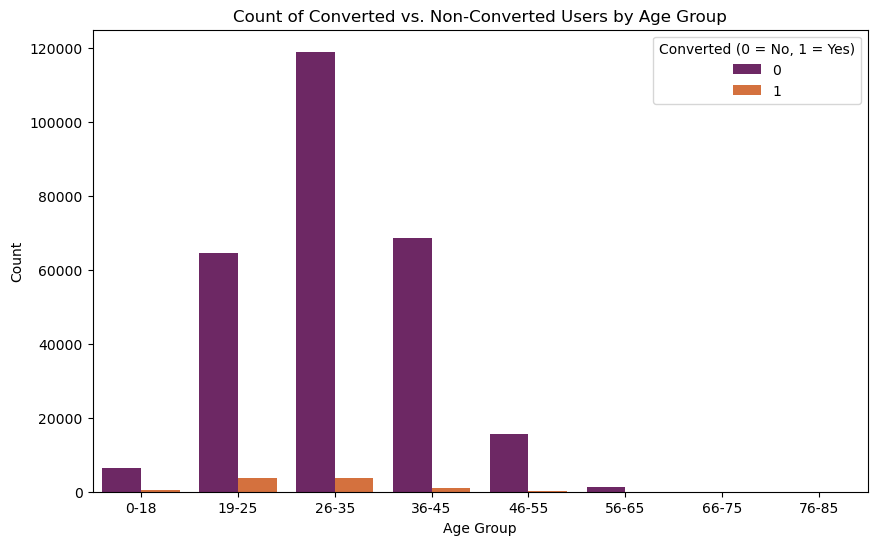

In [14]:
# Age Vs Converted

bins = [0, 18, 25, 35, 45, 55, 65, 75, 85]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
data_clean['age_group'] = pd.cut(data_clean['age'], bins=bins, labels=labels, right=False)


plt.figure(figsize=(10, 6))
sns.countplot(data=data_clean, x='age_group', hue='converted', palette='inferno')
plt.title('Count of Converted vs. Non-Converted Users by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')

plt.legend(title='Converted (0 = No, 1 = Yes)')
plt.show()


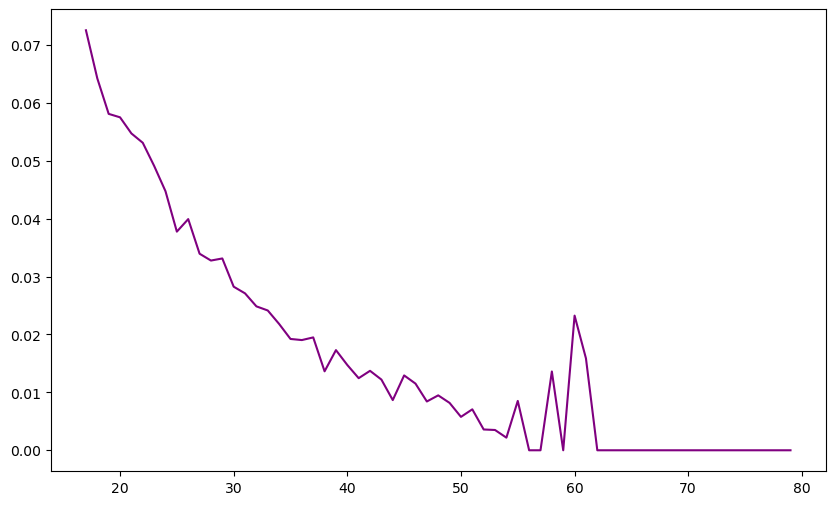

In [15]:
# Let's visualize Age Vs. Converted (mean)
data_ages = data_clean.groupby('age')[['converted']].mean()
plt.figure(figsize=(10, 6))
plt.plot(data_ages.index,data_ages['converted'], color = "purple")
plt.show()

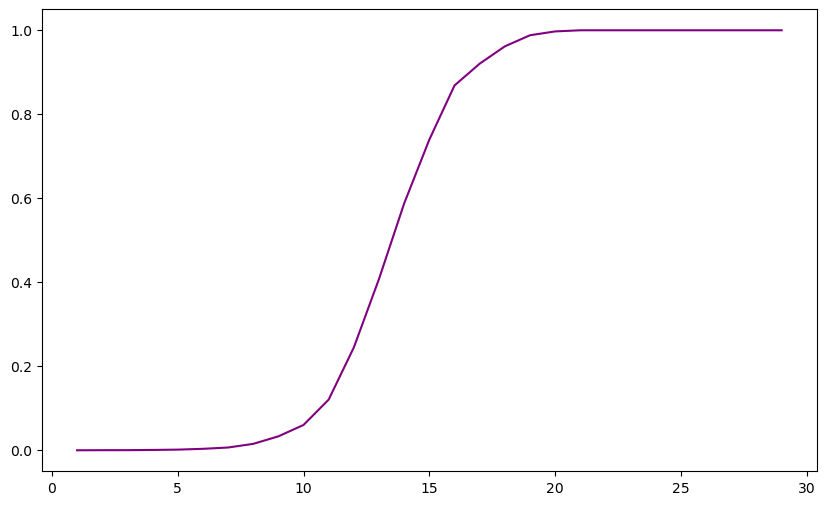

In [16]:
# Let's visualize total_pages_visited Vs. Converted (mean)
data_pages = data_clean.groupby('total_pages_visited')[['converted']].mean()
plt.figure(figsize=(10, 6))
plt.plot(data_pages.index,data_pages['converted'], color = "purple")
plt.show()

Remarks:
- as the age increses, the conversion decreases
- as the the number of pages increases  (up until around 20 pages), the probability of conversion increases

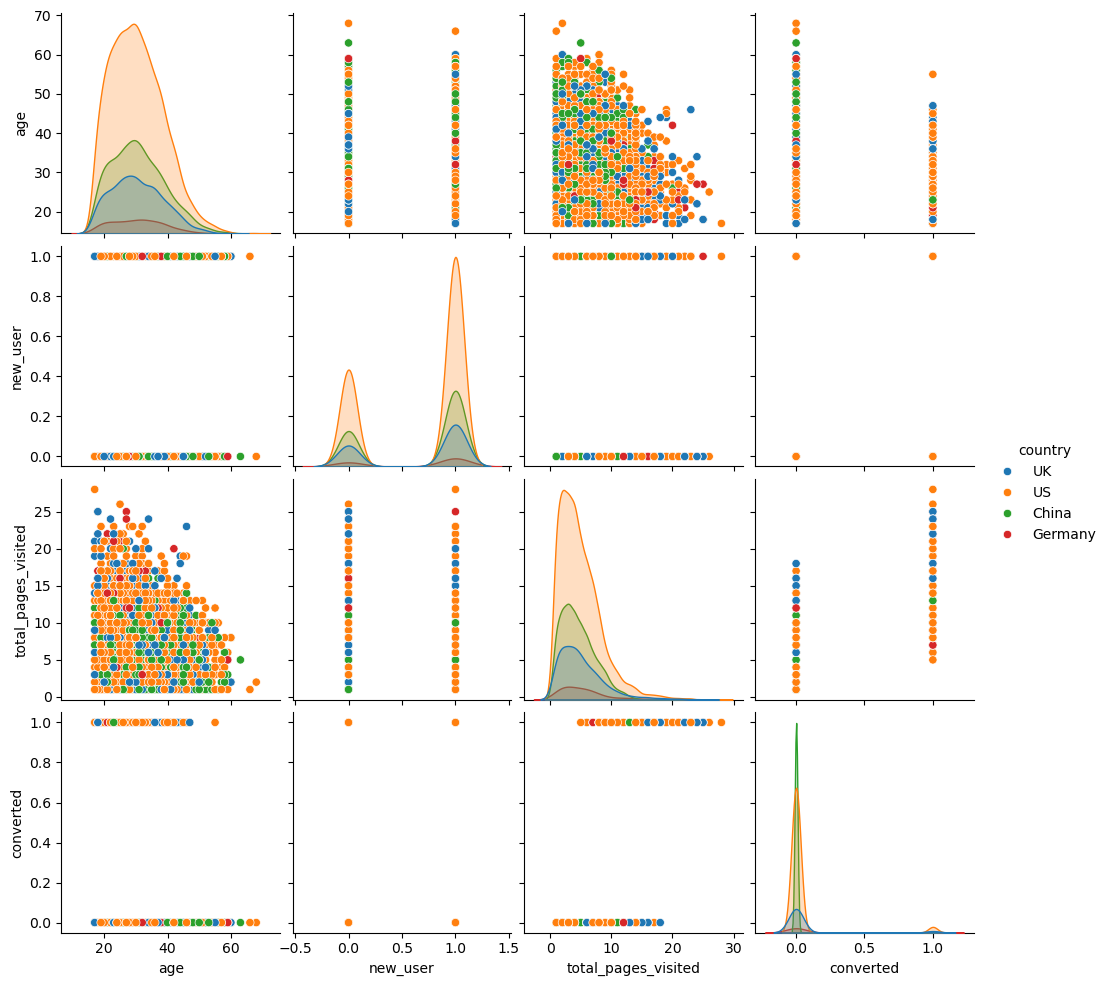

In [17]:
sns.pairplot(data_clean.sample(10000), hue= "country")

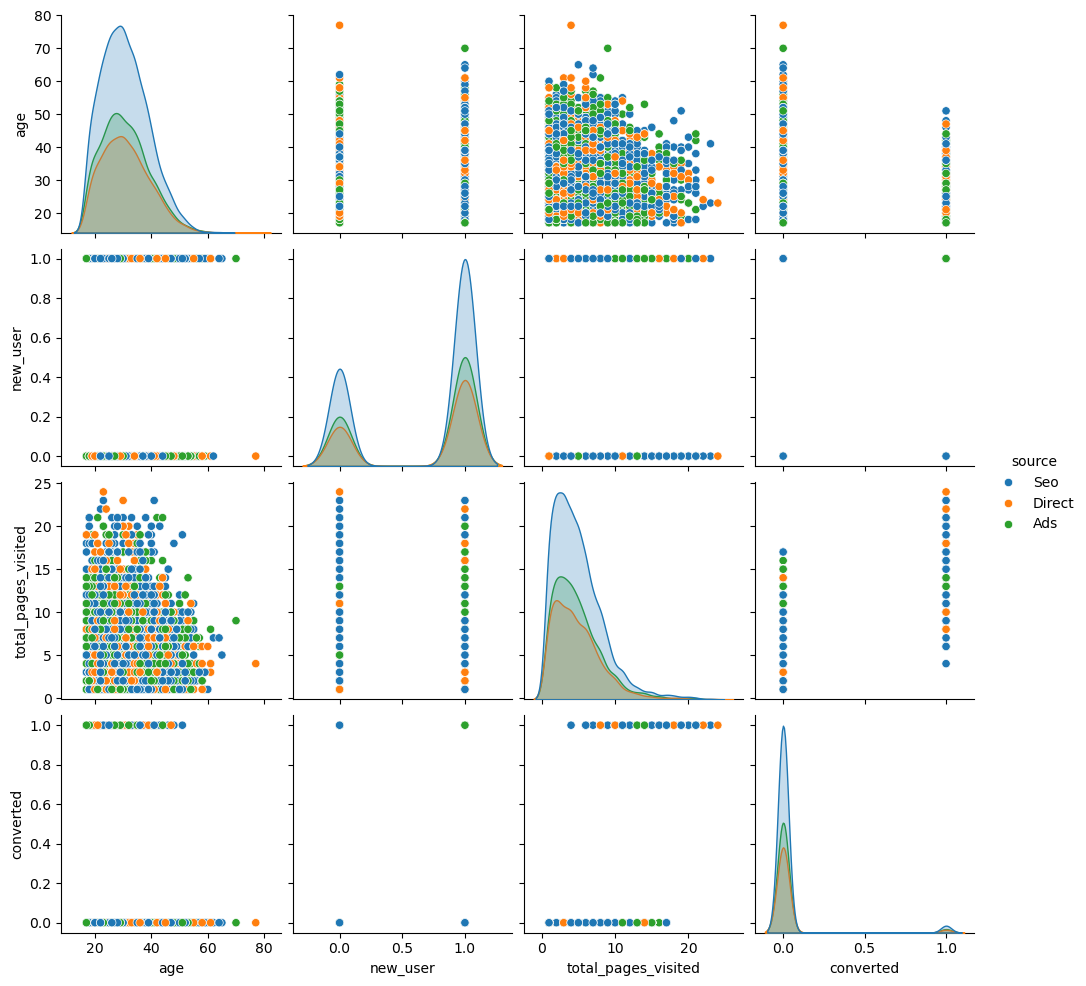

In [18]:
sns.pairplot(data_clean.sample(10000), hue= "source")

In [19]:
data_clean.corr(numeric_only=True)

,age,new_user,total_pages_visited,converted
age,1.000000,0.011789,-0.045555,-0.088711
new_user,0.011789,1.000000,-0.082965,-0.152075
total_pages_visited,-0.045555,-0.082965,1.000000,0.529171
converted,-0.088711,-0.152075,0.529171,1.000000


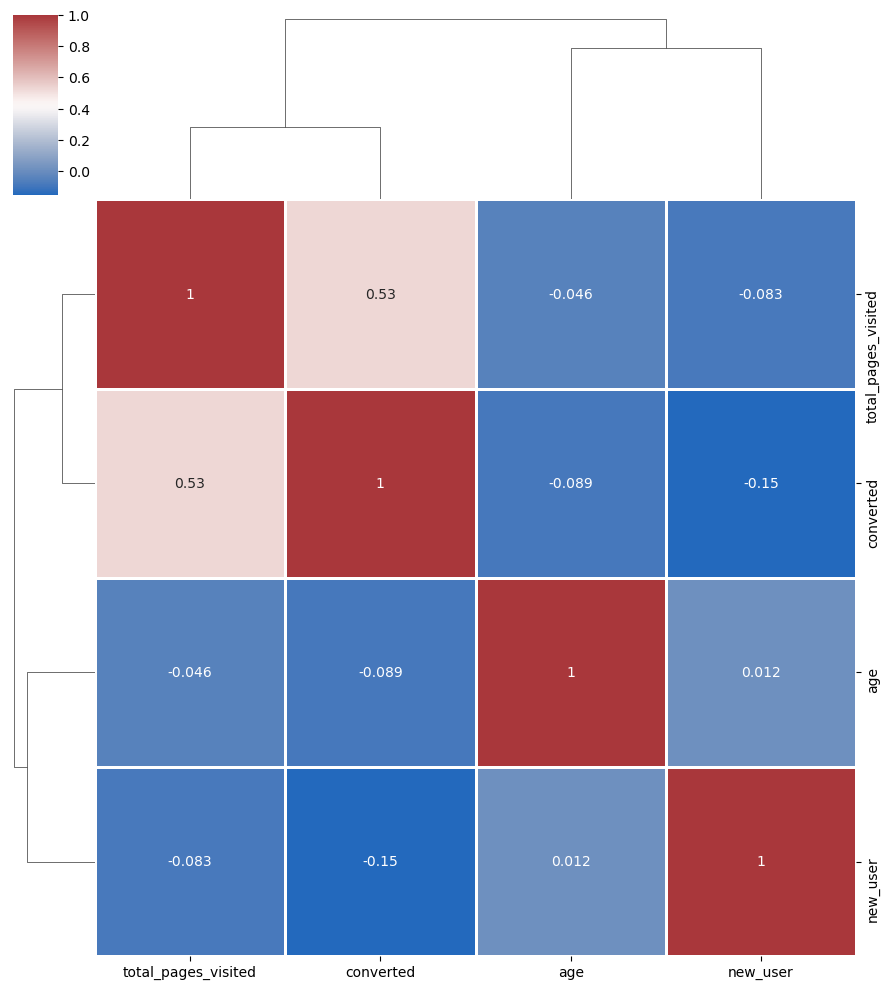

In [20]:
sns.clustermap(data_clean.corr(numeric_only=True), cmap = "vlag", dendrogram_ratio = (0.1, 0.2), annot = True, linewidths = .8, figsize = (9,10))
plt.show()

Remarks:
- No correlation between features
- correlation between total_pages_visited and target (note: correlation index drops from 0.58 to 0.3 after removing outliers)

# Machine learning 👩‍💻

### Preprocessing 🛠

In [21]:
print("Separating labels from features...")
target_variable = "converted"

X = data_clean.drop(target_variable, axis = 1)
Y = data_clean.loc[:,target_variable]

print("...Done.")

Separating labels from features...
...Done.


In [22]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [23]:
numeric_features = ["age", "total_pages_visited"]
categorical_features= ["country","new_user", "source"]

numeric_transformer = StandardScaler()
categorical_transformer =  Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Training 🏃‍♀️ 

In [24]:
print("Encoding ...")
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("... Done!")

Encoding ...
... Done!


In [25]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [26]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



### Testing 👀

In [27]:
print("Predictions on Test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on Test set...
...Done.
[0 1 0 ... 0 0 0]



### Performance 🚀

In [28]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Recall-score on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall-score on test set : ", recall_score(Y_test, Y_test_pred))
print()

print("Precision-score on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision-score on test set : ", precision_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9863556956687617
accuracy on test set :  0.9858973457961441

f1-score on training set :  0.7651227099896302
f1-score on test set :  0.7578439259855189

Recall-score on training set :  0.6890272373540856
Recall-score on test set :  0.6843443516164185

Precision-score on training set :  0.8601126870021372
Precision-score on test set :  0.8490310950878774



Remarks:
- High accuracy on training and Testing. It's not sufficent because of the model's ability to predict "non converted"
- F1_score moderatly high, due to unbalanced distribution
- Moderate recall. The model identifies 68% of "converted"
- Pretty good precision. When the model predicts a "conversion", it's likely to be correct

In [29]:
confusion_matrix(Y_train, Y_train_pred)

array([[192059,    720],
       [  1998,   4427]], dtype=int64)

In [30]:
confusion_matrix(Y_test, Y_test_pred)

array([[82286,   335],
       [  869,  1884]], dtype=int64)

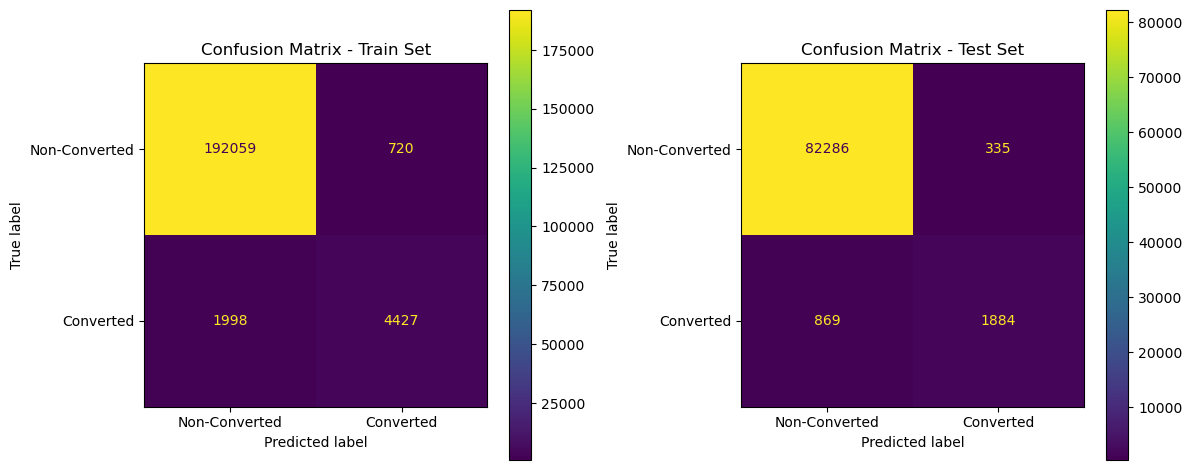

In [31]:
# confusion matrices for train and test sets
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
conf_matrix_test = confusion_matrix(Y_test, Y_test_pred)

# confusion matrices for both train and test sets
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Display confusion matrix for train set
ConfusionMatrixDisplay(conf_matrix_train, display_labels=["Non-Converted", "Converted"]).plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - Train Set")

# Display confusion matrix for test set
ConfusionMatrixDisplay(conf_matrix_test, display_labels=["Non-Converted", "Converted"]).plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()

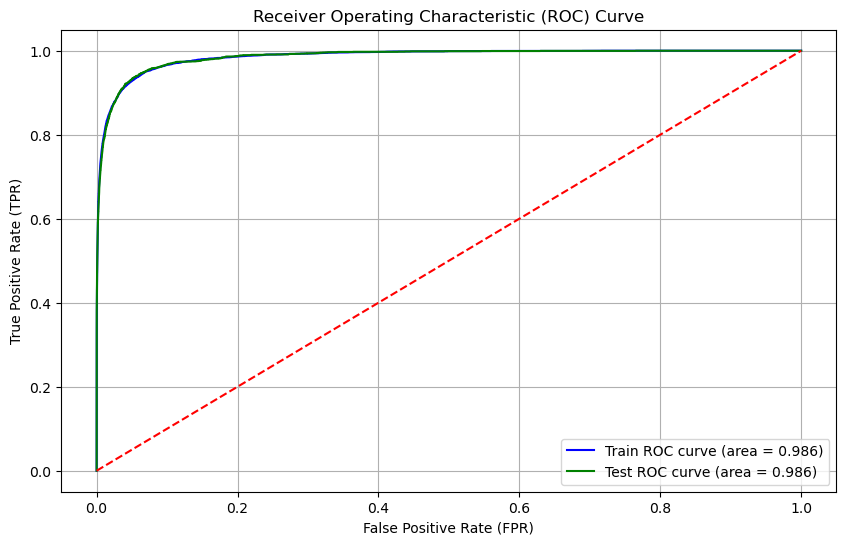

In [32]:
y_train_proba = classifier.predict_proba(X_train)[:, 1] 
y_test_proba = classifier.predict_proba(X_test)[:, 1]

# ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(Y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {roc_auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (area = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [33]:
coefficients = classifier.coef_

num_features = numeric_features
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_features, cat_features])

coeff_df = pd.DataFrame(coefficients.T, all_feature_names, columns=['Coefficient'])

print(coeff_df)

                     Coefficient
age                    -0.629416
total_pages_visited     2.551516
country_Germany         3.468300
country_UK              3.241417
country_US              2.876565
new_user_1             -1.764917
source_Direct          -0.151806
source_Seo             -0.012749


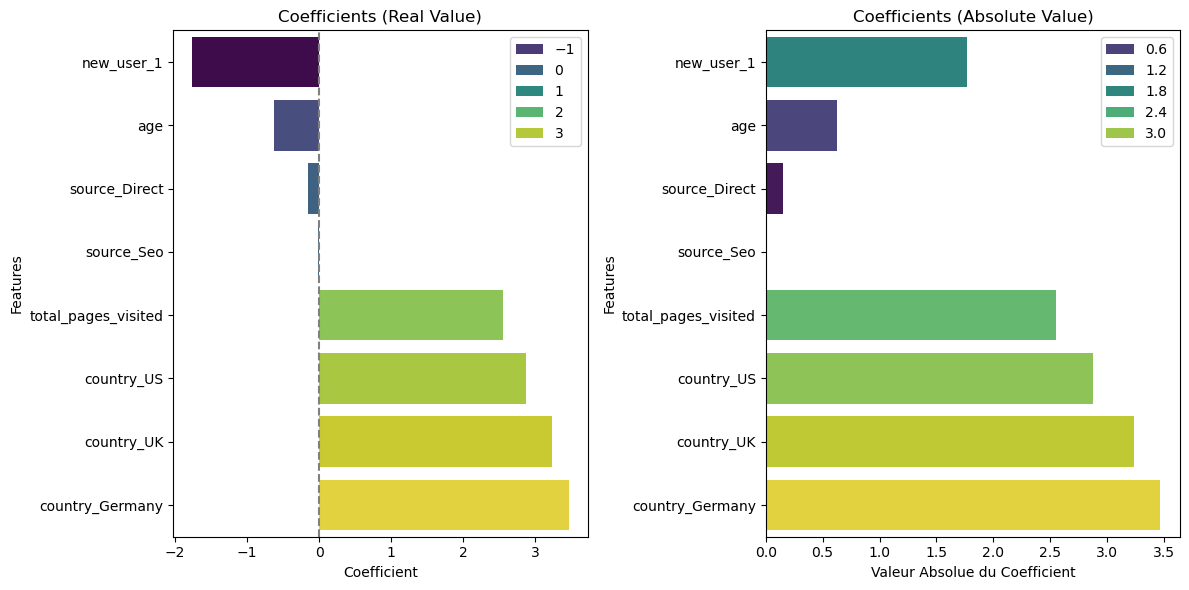

In [34]:
coeff_df = coeff_df.sort_values(by='Coefficient')  
feature_names = coeff_df.index  
coeff_values = coeff_df['Coefficient'].values 


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
sns.barplot(x=coeff_values, y=feature_names,hue=coeff_values, palette='viridis')
plt.axvline(0, color='gray', linestyle='--') 
plt.title('Coefficients (Real Value)')
plt.xlabel('Coefficient')
plt.ylabel('Features')


plt.subplot(1, 2, 2)
sns.barplot(x=np.abs(coeff_values), y=feature_names,hue=np.abs(coeff_values), palette='viridis')
plt.title('Coefficients (Absolute Value)')
plt.xlabel('Valeur Absolue du Coefficient')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

### Improve performance 📈

1. Threshold

In [35]:
y_prob = classifier.predict_proba(X_test)[:, 1] 
y_true = Y_test

thresholds = np.arange(0, 1, 0.01)
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1 Score: {best_f1}")
print(f"Optimal Threshold: {best_threshold}")


Best F1 Score: 0.76166888931225
Optimal Threshold: 0.4


Remark : F1_score increses from 0.757 to 0.761

In [36]:
# include Threshold = 0.4
classifier_threshold = LogisticRegression()
classifier_threshold.fit(X_train,Y_train)

optimal_threshold = 0.4
y_prob = classifier.predict_proba(X_test)[:, 1]
Y_pred_threshold = (y_prob >= optimal_threshold).astype(int)


2. Class_weight

In [37]:
weights = {0: 1, 1: 2} 
classifier_w = LogisticRegression(class_weight=weights)
classifier_w.fit(X_train, Y_train)

Y_train_pred = classifier_w.predict(X_train)
Y_pred_w = classifier_w.predict(X_test)


Class_weight = balanced => Lower performance
- f1-score on test set :  0.5103992114342041
- Recall-score on test set :  0.9404286233200145
- Precision-score on test set :  0.3502435064935065

Custom Class_weight (0:1,1:2)=> better performance
- f1-score on test set :  0.7615553925165077
- Recall-score on test set :  0.7540864511442064
- Precision-score on test set :  0.7691737680622452

Note: Using 0.4 threshold with class_weight lowers performance

3. XG_boost

In [38]:
# Grid search for XGBoost parameters
param_grid = {
    'learning_rate': [0.01, 0.1],       
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1, 5]
}


In [39]:
param_grid = {
    'learning_rate': [0.01, 0.1],       
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1, 5]
}
xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='f1', verbose=1, n_jobs=-1)


In [40]:
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [41]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8, colsample_bytree=0.8, gamma = 1)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)

### Performance Viz / model ✨

In [42]:

# Logistic Regression (default)
acc_default = accuracy_score(Y_test, Y_test_pred)
f1_default = f1_score(Y_test, Y_test_pred)
recall_default = recall_score(Y_test, Y_test_pred)
precision_default = precision_score(Y_test, Y_test_pred)

# Logistic Regression (modified threshold)
acc_threshold = accuracy_score(Y_test, Y_pred_threshold)
f1_threshold = f1_score(Y_test, Y_pred_threshold)
recall_threshold = recall_score(Y_test, Y_pred_threshold)
precision_threshold = precision_score(Y_test, Y_pred_threshold)

# Logistic Regression (class weights)
acc_w = accuracy_score(Y_test, Y_pred_w)
f1_w = f1_score(Y_test, Y_pred_w)
recall_w = recall_score(Y_test, Y_pred_w)
precision_w = precision_score(Y_test, Y_pred_w)

# XGBoost
Y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(Y_test, Y_pred_xgb)
f1_xgb = f1_score(Y_test, Y_pred_xgb)
recall_xgb = recall_score(Y_test, Y_pred_xgb)
precision_xgb = precision_score(Y_test, Y_pred_xgb)


In [43]:
model_performance = {
    "Model": [
        "Logistic Regression (Default)",
        "Logistic Regression (Threshold Mod)",
        "Logistic Regression (Class Weight)",
        "XGBoost"
    ],
    "Accuracy": [
        acc_default, 
        acc_threshold, 
        acc_w, 
        acc_xgb
    ],
    "F1-Score": [
        f1_default, 
        f1_threshold, 
        f1_w, 
        f1_xgb
    ],
    "Recall": [
        recall_default, 
        recall_threshold, 
        recall_w, 
        recall_xgb
    ],
    "Precision": [
        precision_default, 
        precision_threshold, 
        precision_w, 
        precision_xgb
    ]
}

performance_df = pd.DataFrame(model_performance)


In [44]:
performance_df

,Model,Accuracy,F1-Score,Recall,Precision
0,Logistic Regression (Default),0.985897,0.757844,0.684344,0.849031
1,Logistic Regression (Threshold Mod),0.985347,0.761669,0.726117,0.800881
2,Logistic Regression (Class Weight),0.984773,0.761555,0.754086,0.769174
3,XGBoost,0.985733,0.758045,0.693062,0.836475


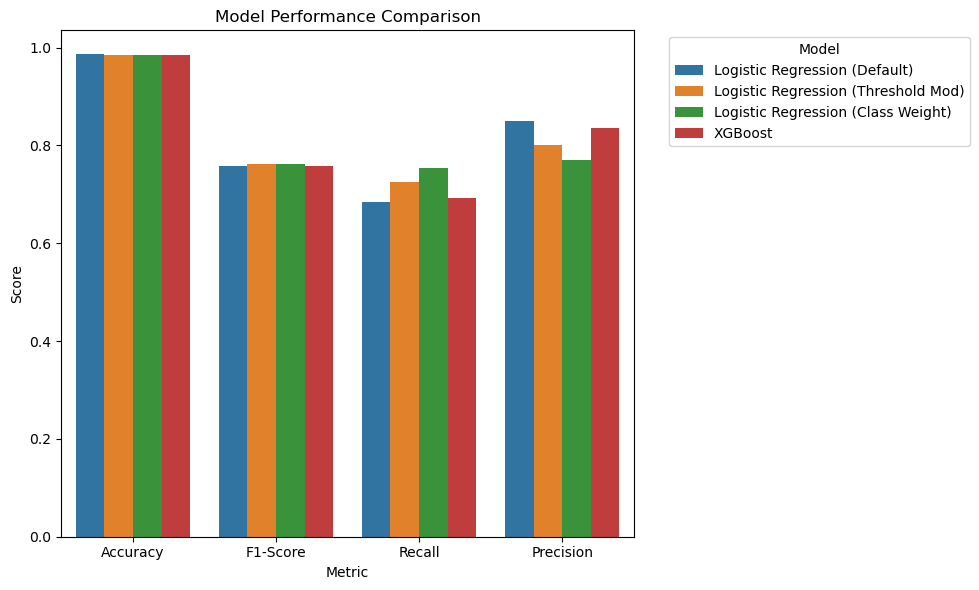

In [45]:
df_melted = performance_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
#plt.ylim(0.65, 1.0)  # Set y-axis limits to focus on the performance range
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Further more:
- ADA BOOST
- Random Forest 
- SMOT 
- Feature ingeneering 